**Подключение библиотек**

In [ ]:
import numpy as np
import numpy.random as npr
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.special import boxcox, inv_boxcox
from statsmodels.tsa.seasonal import STL

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.3 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:
from statsmodels.tsa.stattools import adfuller

**Linear process bootstrap**

In [ ]:
# оценка автокорелляционной функции
def wacf(x, lag_max=None):
    if lag_max is None:
        lag_max = len(x) - 1
    n = len(x)
    lag_max = min(lag_max, n - 1)
    if lag_max < 0:
        raise ValueError("'lag_max' must be at least 0")

    # стандартная оценка acf
    acfest = sm.tsa.acf(x, nlags=n, fft=False)

    # конусная оценка
    s = np.arange(1, n + 1)
    upper = 2 * np.sqrt(np.log10(n) / n)
    ac = np.abs(acfest)
    # находим l
    j = ac < upper
    l = 0
    k = 1
    N = len(j) - 4
    while l < 1 and k <= N:
        if np.all(j[(k-1):(k + 4)]):
            l = k
        else:
            k += 1
    acfest = acfest * kappa(s / l)

    # построим матрицу ковариации
    gamma = acfest
    s = len(gamma)
    Gamma = np.ones((s, s))
    d = np.subtract.outer(np.arange(s), np.arange(s))
    for i in range(1, s):
        Gamma[np.logical_or(d == i, d == -i)] = gamma[i]

    # находим собственные значенияя и векторы с помощью разложения
    eig_vals, eig_vecs = np.linalg.eig(Gamma)

    # сократим собственные значения
    d = np.maximum(eig_vals, 20 / n)

    # строим новую ковариационную матрицу
    Gamma2 = np.dot(np.dot(eig_vecs, np.diag(d)), eig_vecs.T)
    Gamma2 = Gamma2 / np.mean(d)

    # оцениваем новую ACF
    d = np.subtract.outer(np.arange(s), np.arange(s))
    for i in range(1, s):
        gamma[i] = np.mean(Gamma2[d == i])
    acfest = gamma

    return acfest

In [ ]:
# корневая функция
def kappa(x):
    k = np.zeros(len(x))
    x = np.abs(x)
    k[x <= 1] = 1
    k[np.logical_and(x > 1, x <= 2)] = 2 - x[np.logical_and(x > 1, x <= 2)]
    return k

In [ ]:
# Linear process bootstrap
def lpb(x, nsim=100):
    n = len(x)
    meanx = np.mean(x)
    y = x - meanx
    gamma = wacf(y, n)
    s = len(gamma)
    Gamma = np.ones((s, s))
    d = np.subtract.outer(np.arange(s), np.arange(s))

    for i in range(1, s):
        Gamma[np.logical_or(d == i, d == -i)] = gamma[i]

    L = np.linalg.cholesky(Gamma)
    W = np.linalg.solve(L, np.matrix(y).T)
    out = np.dot(L, npr.normal(size=(n, nsim))) + meanx
    out = np.squeeze(np.asarray(out))
    out = np.transpose(out)
    return out

**Bagging**

In [ ]:
# алгоритм Бергмайра для формирования выборок из временного ряда
def bergmeir(dataset, is_seasonal, number_of_bs):
  lam = stats.boxcox_normmax(dataset, brack = (0.0, 1.0))
  bc = boxcox(dataset, lam)
  if is_seasonal:
    stl = STL(bc)
    stl = stl.fit()
    seasonal, trend, remainder = stl.seasonal, stl.trend, stl.resid
  else:
    seasonal = pd.Series([0] * len(bc))
    trend, remainder = zip(*lowess(bc.index, bc.values))
    trend = pd.Series(trend)
    remainder = pd.Series(remainder)
  result = [dataset]
  for i in range(number_of_bs):
    restored = trend.values + seasonal.values + lpb(remainder, 1)
    restored = inv_boxcox(restored, lam)
    if np.isnan(sum(restored)): print("restored2 is nan")
    restored = pd.Series(data = restored, index=dataset.index)
    result.append(restored)
  return result

In [ ]:
# предсказание с помощью ETS
def ets_forecast(train, test):
  model = ExponentialSmoothing(train, trend="add", seasonal="add")
  model_fit = model.fit()
  forecast = model_fit.forecast(len(test))
  return forecast

In [ ]:
def arima_forecast(train, test, model_params):
  model = auto_arima(train, **model_params)
  forecast = model.predict(len(test))
  return forecast

In [ ]:
# предсказание с помощью бэггинга
def bagging_forecast(train, test, model_name):
  forecasts = []
  if model_name == "arima":
    arima = auto_arima(train[0])
    arima_params = arima.get_params()
  # получаем предсказания для псевдовыборок
  for i, sample in enumerate(train):
    if model_name == "ets":
      fc = ets_forecast(train[i], test)
    if model_name == "arima":
      fc = arima_forecast(train[i], test, arima_params)
    forecasts.append(fc)
    #print(f"forecast for train[{i}]:", fc)
  return np.mean(forecasts, axis = 0)

In [ ]:
def printer(t, p):
  print("Pred: \t", p)
  print("Test: \t", t.values)
  RMSE = mean_squared_error(t, p, squared = False)
  print('RMSE:', RMSE)
  MAE = mean_absolute_error(t, p)
  print('MAE:', MAE)
  plt.figure(figsize=(10,4))
  plt.scatter(t.index, p, color = 'red')
  plt.plot(t.index, p, color = 'red', alpha = 0.5)
  plt.scatter(t.index, t, color = 'green')
  plt.plot(t.index, t, color = 'green', alpha = 0.5)
  plt.show()

In [ ]:
def test_stationarity(timeseries):
    # Определение статистики ряда
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()

    # Визуализация скользящего среднего и стандартного отклонения
    plt.plot(timeseries, label='Original')
    plt.plot(rolling_mean, label='Rolling Mean')
    plt.plot(rolling_std, label='Rolling Std')
    plt.legend()
    plt.show()

    # Тест Дики-Фуллера
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    # Проверка стационарности по p-value
    if result[1] <= 0.05:
        print("Ряд стационарен")
    else:
        print("Ряд нестационарен")

Загрузка датасетов

In [ ]:
class SophistHSE:
    def __init__(self):
        self.url = 'http://sophist.hse.ru/hse/1/tables/'

    #Transform str index to datetime index
    def __time_to_datetime__(self, df):
        current_year = df.index[0].split()[0]
        new_index = []
        for index, row in df.iterrows():
            lst = index.split()
            if len(lst) == 2:
                current_year = lst[0]
                new_index.append(pd.to_datetime(index))
            else:
                new_index.append(pd.to_datetime(current_year + ' ' + lst[0]))

        df.index = new_index
        return df

    #Parse Table
    def get_table(self, table):
        df = pd.read_html(self.url + table + '.htm', index_col = 0, decimal = ',', thousands = None,  na_values = '&nbsp')[0]
        df.rename(columns = df.iloc[0], inplace=True)
        df = df[df.index.notna()]
        df = df.drop(index = ['T'])
        df = self.__time_to_datetime__(df).astype(float)
        return df

dataset#1: Доходы федерального бюджета

In [ ]:
HSE = SophistHSE()
table = 'GOV_M' #Put here name of dataset
df = HSE.get_table(table)

In [ ]:
df

2008-10-01     937.1
2008-11-01     570.6
2008-12-01     612.5
2009-01-01     772.0
2009-02-01     448.3
               ...  
2015-11-01     838.8
2015-12-01    1479.6
2016-01-01    1094.0
2016-02-01     747.9
2016-03-01    1068.8
Name: FBREV_M, Length: 90, dtype: float64

In [ ]:
df = df['FBREV_M']

In [ ]:
df = df.drop(df.index[-90:])

In [ ]:
df = df.tail(90)

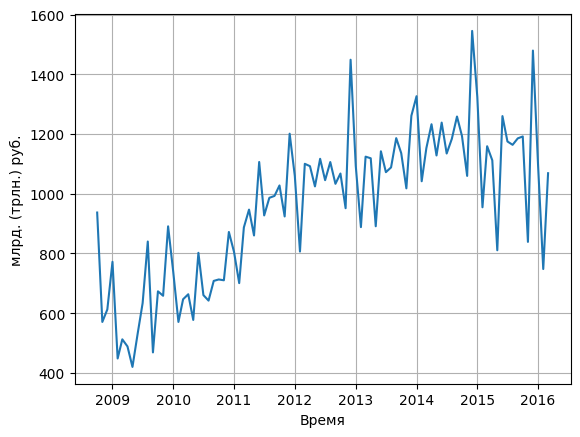

In [ ]:
plt.plot(df)

# Добавьте пояснения к осям
plt.xlabel('Время')
plt.ylabel('млрд. (трлн.) руб.')
plt.grid(True)
# Отобразите график
plt.show()

In [ ]:
train = df.head(80)
test = df.tail(10)

<Figure size 640x480 with 0 Axes>

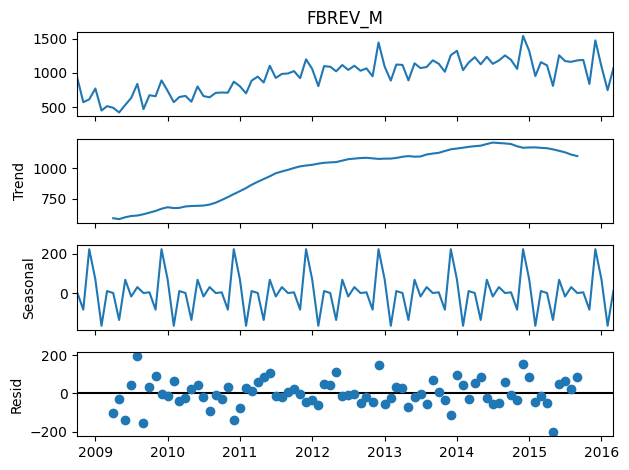

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive', period=12)
plt.figure()
result.plot()
plt.gcf().suptitle('')
plt.show()

In [ ]:
bs = bergmeir(train, is_seasonal=True, number_of_bs=5)
print("ets:")
bagging_ets_forecast = bagging_forecast(bs, test, "ets")
ets_pred = ets_forecast(bs[0], test)
print("arima:")
bagging_arima_forecast = bagging_forecast(bs, test, "arima")

ets:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

arima:


In [ ]:
model = auto_arima(train)
arima_pred = model.predict(start=test.index[0], end=test.index[-1])

In [ ]:
train_diff = train.diff(1).dropna()
model = auto_arima(train_diff)
arima_pred = model.predict(start=test.index[0], end=test.index[-1])
cumsum = train.iloc[0] + train_diff.cumsum()

Pred: 	 [1188.82237955 1107.13677581 1150.20472188 1196.45236473 1154.73060374
 1027.72195745 1433.06400649 1279.3798987   960.71809345 1152.8658539 ]
Test: 	 [1260.1 1175.1 1163.9 1185.5 1191.9  838.8 1479.6 1094.   747.9 1068.8]
RMSE: 116.60617402424248
MAE: 91.87796807573208


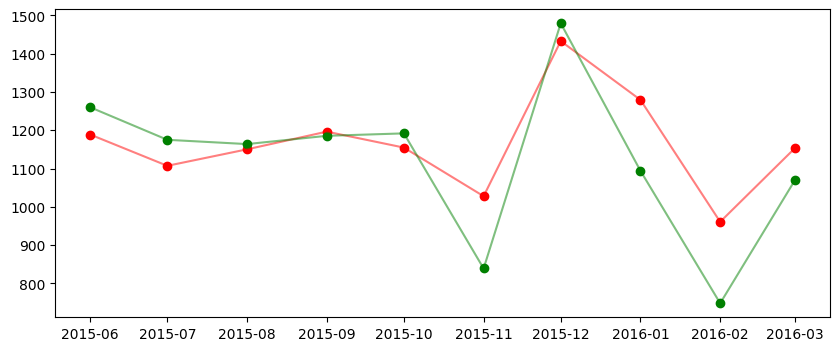

In [ ]:
printer(test, bagging_ets_forecast)

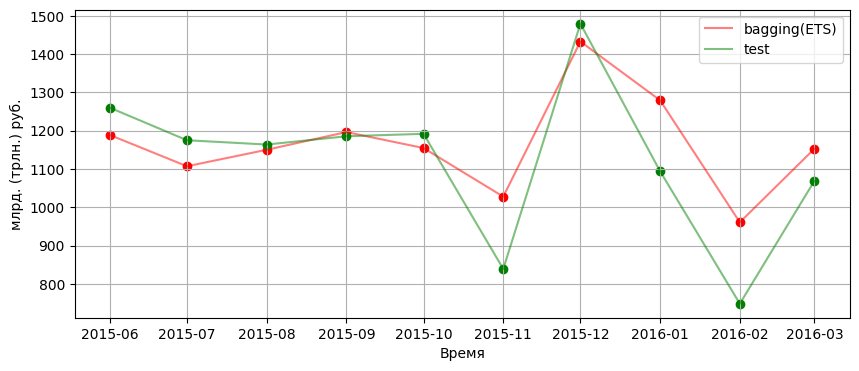

In [ ]:
t = test
p = bagging_ets_forecast
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='bagging(ETS)')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд. (трлн.) руб.')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 2015-06-01    1152.354409
2015-07-01    1075.374279
2015-08-01    1139.649680
2015-09-01    1106.437538
2015-10-01    1173.629235
2015-11-01    1057.423575
2015-12-01    1333.367997
2016-01-01    1222.993394
2016-02-01     981.443489
2016-03-01    1148.956055
Freq: MS, dtype: float64
Test: 	 [1260.1 1175.1 1163.9 1185.5 1191.9  838.8 1479.6 1094.   747.9 1068.8]
RMSE: 132.48170441923506
MAE: 113.66033758830929


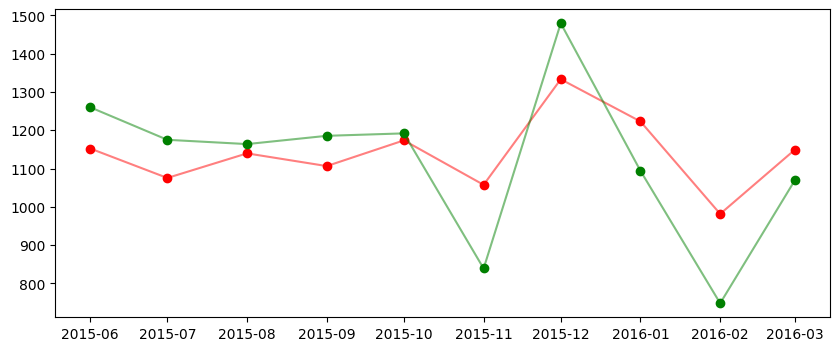

In [ ]:
printer(test, ets_pred)

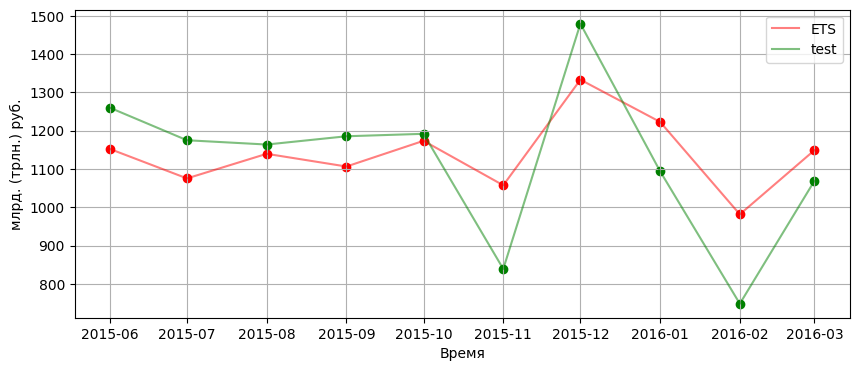

In [ ]:
t = test
p = ets_pred
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='ETS')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд. (трлн.) руб.')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 2015-06-01    1049.445573
2015-07-01    1059.612052
2015-08-01     911.978065
2015-09-01    1009.365560
2015-10-01    1028.067465
2015-11-01     957.654506
2015-12-01     995.949429
2016-01-01    1010.578008
2016-02-01     977.796525
2016-03-01     992.139852
Freq: MS, dtype: float64
Test: 	 [1260.1 1175.1 1163.9 1185.5 1191.9  838.8 1479.6 1094.   747.9 1068.8]
RMSE: 221.98525710888822
MAE: 191.051502732379


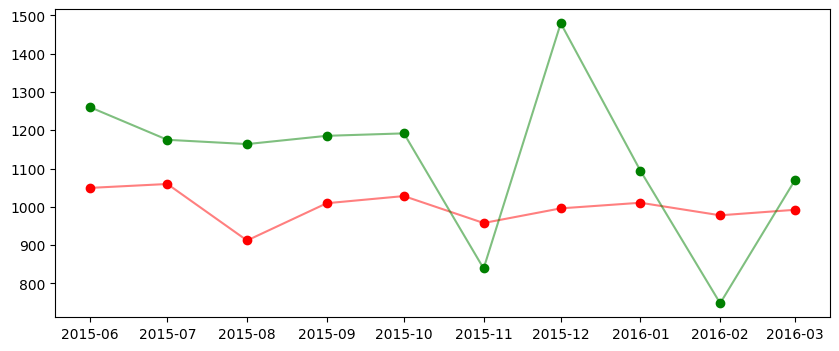

In [ ]:
printer(test, arima_pred)

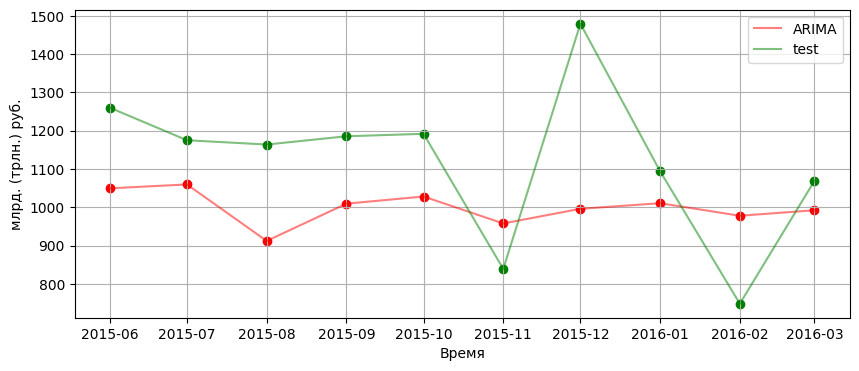

In [ ]:
t = test
p = arima_pred
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='ARIMA')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд. (трлн.) руб.')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 [1079.00495565 1079.31894719  956.87653956 1049.14288651 1052.23383843
  995.11261937 1036.40035434 1039.10839367 1012.5929948  1031.0056678 ]
Test: 	 [1260.1 1175.1 1163.9 1185.5 1191.9  838.8 1479.6 1094.   747.9 1068.8]
RMSE: 204.52175429505905
MAE: 171.68140310124016


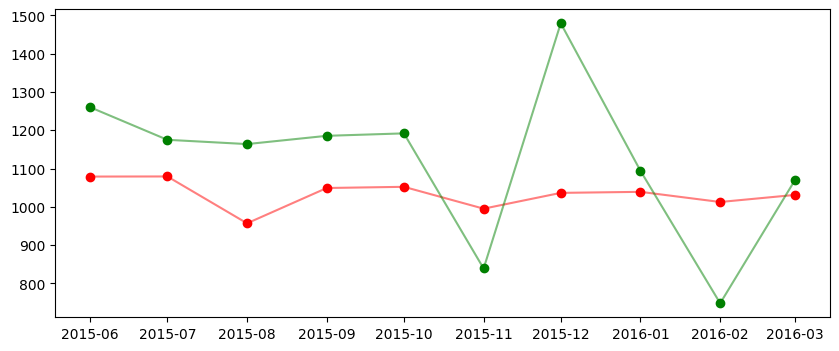

In [ ]:
printer(test, bagging_arima_forecast)

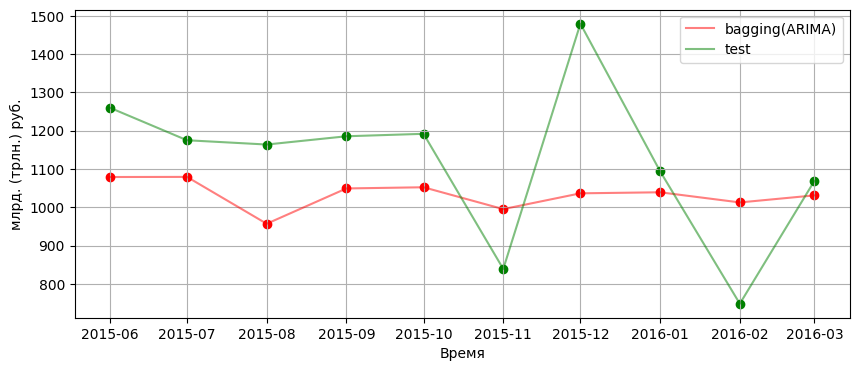

In [ ]:
t = test
p = bagging_arima_forecast
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='bagging(ARIMA)')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд. (трлн.) руб.')
plt.legend()
plt.grid(True)
plt.show()

dataset#2 Индекс производства в секторе "Обеспечение электрической энергией, газом и паром; кондиционирования воздуха"

In [ ]:
table2 = 'IP2_DEA_M'
df2 = HSE.get_table(table2)

In [ ]:
df2

,IP2_DEA_M,IP2_DEA_M_SA
2014-01-01,100.0,77.1
2014-02-01,91.2,76.6
2014-03-01,87.0,76.0
2014-04-01,74.5,75.4
2014-05-01,61.7,74.9
...,...,...
2023-06-01,61.3,82.7
2023-07-01,63.1,83.0
2023-08-01,65.0,83.0
2023-09-01,65.5,82.7


In [ ]:
df2 = df2['IP2_DEA_M']

In [ ]:
df2 = df2.drop(df2.index[-10:])

In [ ]:
df2 = df2.drop(df2.index[:10])

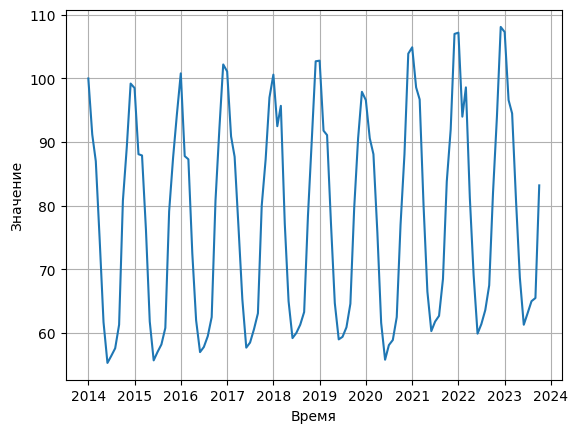

In [ ]:
plt.plot(df2)

# Добавьте пояснения к осям
plt.xlabel('Время')
plt.ylabel('Значение')
plt.grid(True)
# Отобразите график
plt.show()

In [ ]:
train2 = df2.head(-12)
test2 = df2.tail(12)

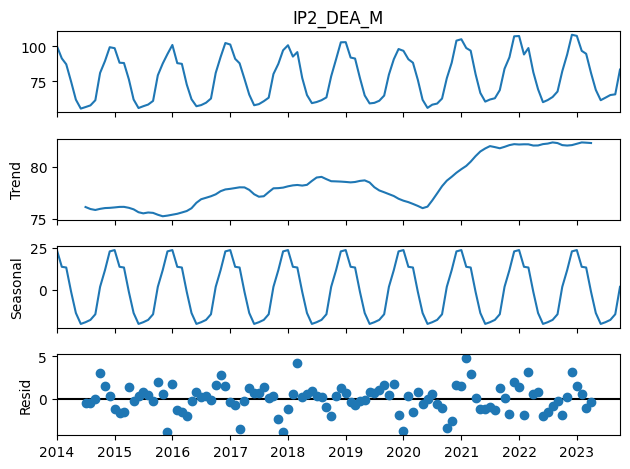

In [ ]:
result = seasonal_decompose(df2, model='additive', period=12)
result.plot()
plt.show()

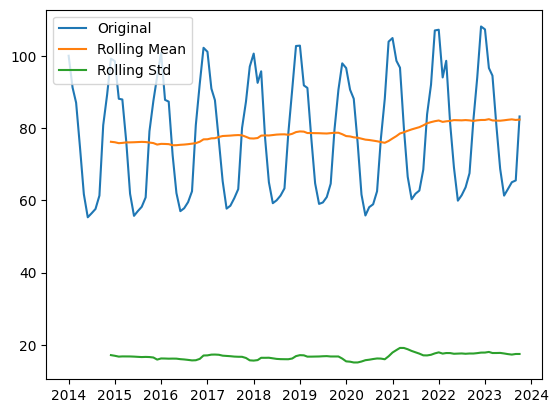

ADF Statistic: -0.7092129733832045
p-value: 0.8443487157587781
Critical Values: {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}
Ряд нестационарен


In [ ]:
test_stationarity(df2)

In [ ]:
bs2 = bergmeir(train2, is_seasonal=True, number_of_bs=5)
print("ets:")
bagging_ets_forecast_2 = bagging_forecast(bs2, test2, "ets")
ets_pred_2 = ets_forecast(bs2[0], test2)
print("arima:")
bagging_arima_forecast_2 = bagging_forecast(bs2, test2, "arima")
model = auto_arima(train2)
arima_pred_2 = model.predict(len(test2))

ets:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_date

arima:


Pred: 	 [ 93.23039293 104.02174805 105.07449124  95.28621971  94.50842288
  80.32872058  68.0400962   60.95092063  62.60278093  63.95993667
  66.53438348  83.64631308]
Test: 	 [ 94.  108.1 107.3  96.6  94.5  80.7  68.7  61.3  63.1  65.   65.5  83.2]
RMSE: 1.5054538016584564
MAE: 1.0661510419222069


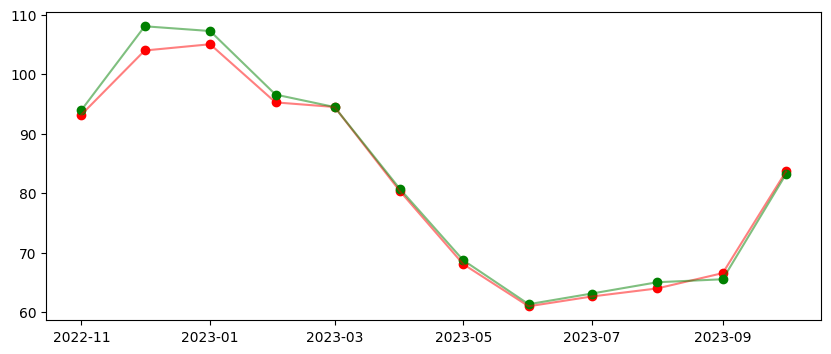

In [ ]:
printer(test2, bagging_ets_forecast_2)

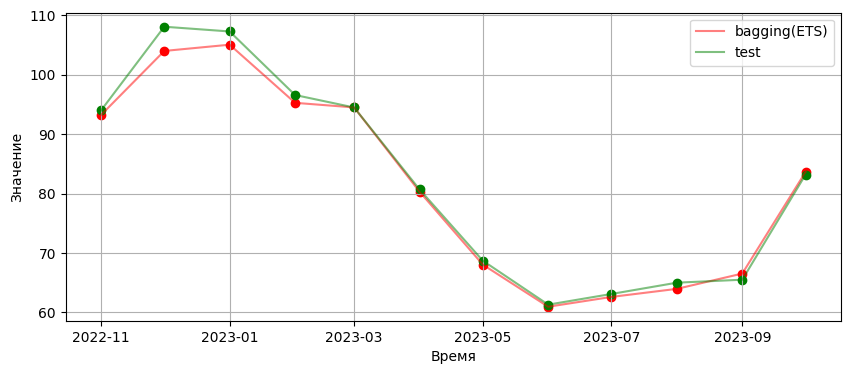

In [ ]:
t = test2
p = bagging_ets_forecast_2
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='bagging(ETS)')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 2022-11-01     92.689378
2022-12-01    103.514500
2023-01-01    104.586243
2023-02-01     94.919663
2023-03-01     94.319701
2023-04-01     79.975184
2023-05-01     67.386227
2023-06-01     60.964057
2023-07-01     62.130734
2023-08-01     63.564005
2023-09-01     66.986232
2023-10-01     83.363952
Freq: MS, dtype: float64
Test: 	 [ 94.  108.1 107.3  96.6  94.5  80.7  68.7  61.3  63.1  65.   65.5  83.2]
RMSE: 1.838627120567058
MAE: 1.408374280617447


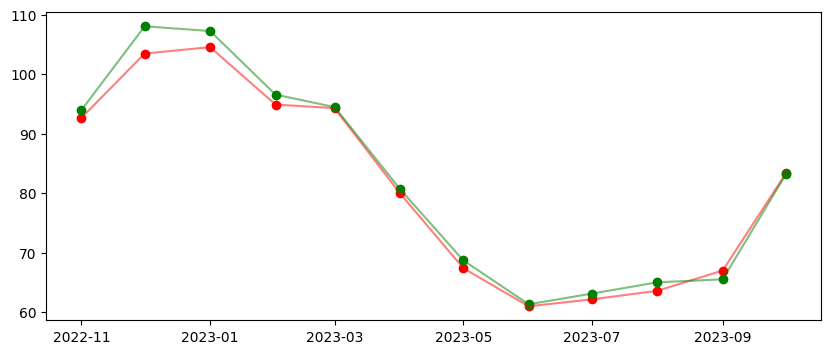

In [ ]:
printer(test2, ets_pred_2)

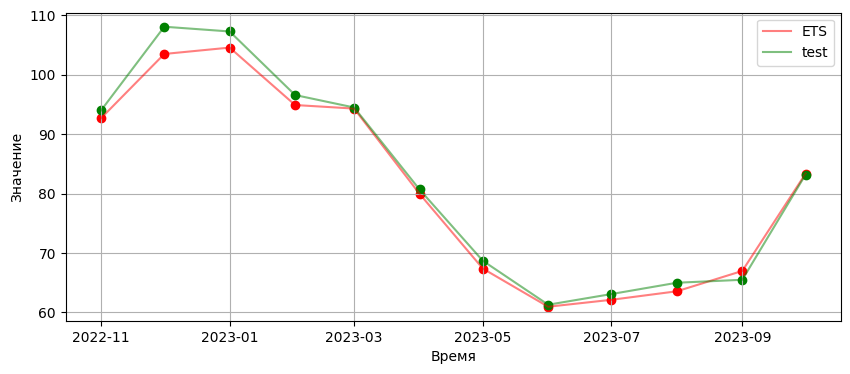

In [ ]:
t = test2
p = ets_pred_2
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='ETS')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 [ 89.94824731  97.32705038 100.08577374  96.88399314  88.45196173
  77.49566574  66.74939592  58.9808924   56.37225522  59.62862934
  67.77348543  78.64790247]
Test: 	 [ 94.  108.1 107.3  96.6  94.5  80.7  68.7  61.3  63.1  65.   65.5  83.2]
RMSE: 5.32785915383918
MAE: 4.564142027644734


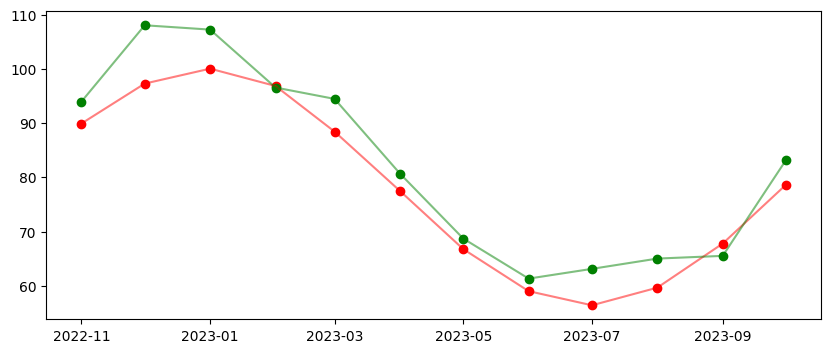

In [ ]:
printer(test2, bagging_arima_forecast_2)

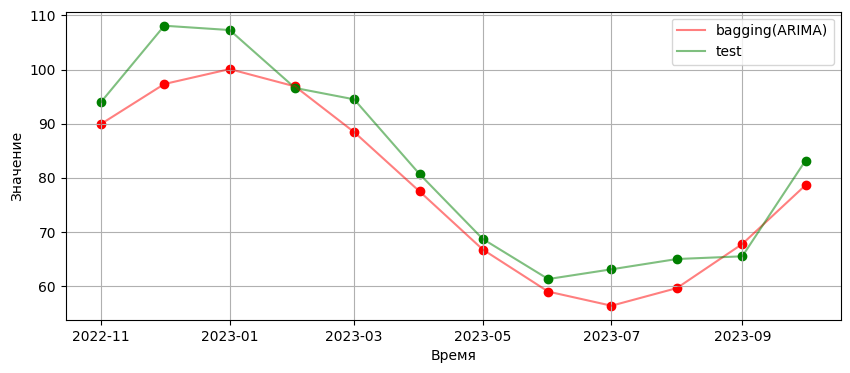

In [ ]:
t = test2
p = bagging_arima_forecast_2
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='bagging(ARIMA)')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 2022-11-01     90.583537
2022-12-01     99.025627
2023-01-01    101.873186
2023-02-01     98.372818
2023-03-01     89.464593
2023-04-01     77.529585
2023-05-01     65.753447
2023-06-01     57.276105
2023-07-01     54.354553
2023-08-01     57.761956
2023-09-01     66.583054
2023-10-01     78.459998
Freq: MS, dtype: float64
Test: 	 [ 94.  108.1 107.3  96.6  94.5  80.7  68.7  61.3  63.1  65.   65.5  83.2]
RMSE: 5.318232513883826
MAE: 4.72277376593158


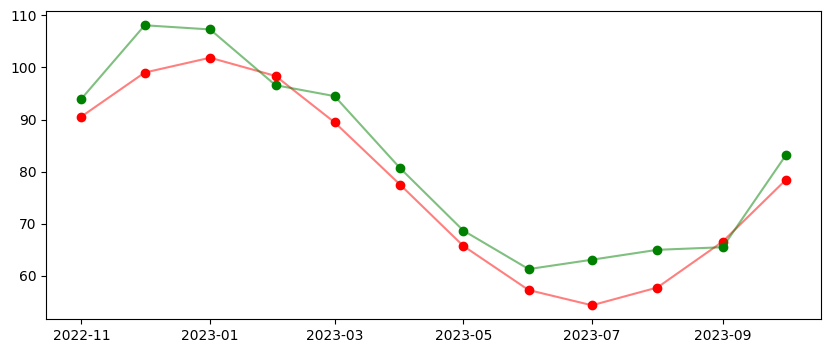

In [ ]:
printer(test2, arima_pred_2)

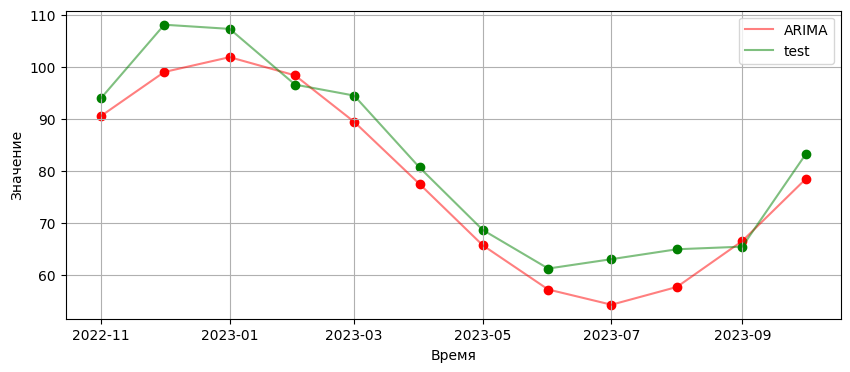

In [ ]:
t = test2
p = arima_pred_2
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='ARIMA')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)
plt.show()

dataset#3: Кредиторская задолженность предприятия

In [ ]:
table3 = 'FINENT_M'
df3 = HSE.get_table(table3)

In [ ]:
df3

,LIAB_T_M,LIAB_UNP_M,LIAB_S_M,LIAB_B_M,DBT_T_M,DBT_UNP_M,DBT_P_M
1994-01-01,53.7,19.9,13.5,3.4,49.9,21.4,19.3
1994-02-01,63.4,25.0,17.4,4.2,59.7,25.7,23.2
1994-03-01,80.5,30.5,20.2,5.2,70.5,30.8,27.7
1994-04-01,89.5,36.9,25.1,6.8,79.5,35.6,32.8
1994-05-01,98.6,41.6,28.3,8.7,87.8,39.7,34.8
...,...,...,...,...,...,...,...
2023-03-01,92613.0,4134.8,2739.4,53.8,88615.4,4721.8,3660.5
2023-04-01,96313.1,4182.8,2754.8,55.5,92558.8,4906.1,3812.5
2023-05-01,98022.8,4347.0,2872.3,57.0,92975.9,5082.5,3897.0
2023-06-01,97964.2,4389.5,2820.4,57.3,93581.9,5365.5,4024.5


In [ ]:
df3 = df3['LIAB_T_M']

In [ ]:
df3 = df3.drop(df3.index[-60:])

In [ ]:
df3 = df3.drop(df3.index[:30])

In [ ]:
df3 = df3.dropna()

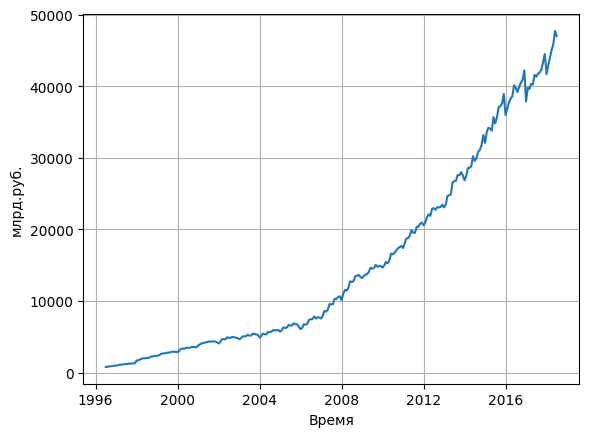

In [ ]:
plt.plot(df3)

# Добавьте пояснения к осям
plt.xlabel('Время')
plt.ylabel('млрд.руб.')
plt.grid(True)
# Отобразите график
plt.show()

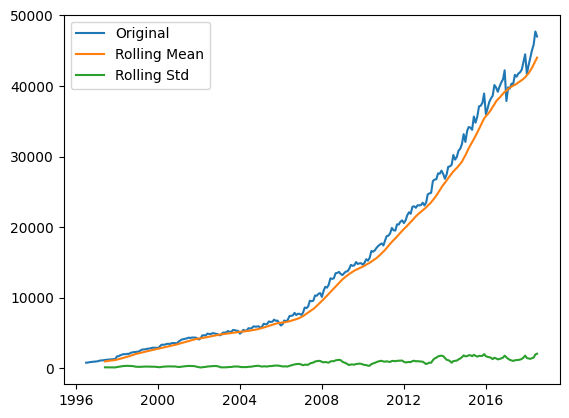

ADF Statistic: 2.6775926671708357
p-value: 0.9990855070606093
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}
Ряд нестационарен


In [ ]:
test_stationarity(df3)

In [ ]:
train3 = df3.head(-12)
test3 = df3.tail(12)

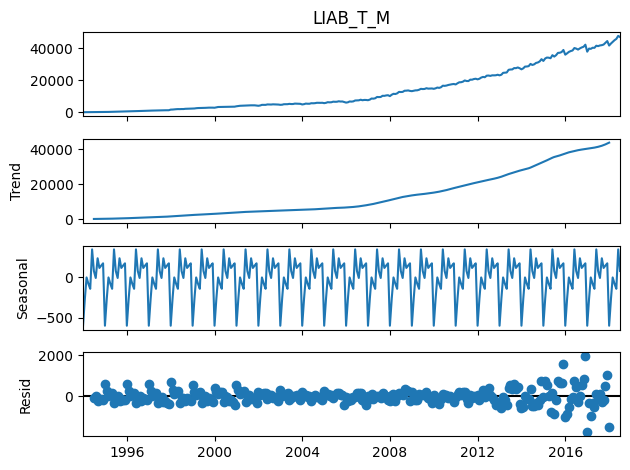

In [ ]:
result = seasonal_decompose(df3, model='additive', period=12)
result.plot()
plt.show()

In [ ]:
bs3 = bergmeir(train3, is_seasonal=True, number_of_bs=20)
print("ets:")
bagging_ets_forecast_3 = bagging_forecast(bs3, test3, "ets")
ets_pred_3 = ets_forecast(bs3[0], test3)
print("arima:")
bagging_arima_forecast_3 = bagging_forecast(bs3, test3, "arima")
model = auto_arima(train3)
arima_pred_3 = model.predict(len(test3))

ets:


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmode

arima:


Pred: 	 [46707.27120546 47059.20832269 46951.13189267 46814.29229116
 47095.506765   47061.47872359 47689.37982271 47933.49683622
 47884.68677443 47885.29800157 47886.59408943 47896.36643018]
Test: 	 [41745.5 41931.3 42305.  43446.3 44481.3 41690.4 42971.2 43915.1 45040.1
 45822.8 47718.6 47005.2]
RMSE: 3776.062765197775
MAE: 3399.3259295909806


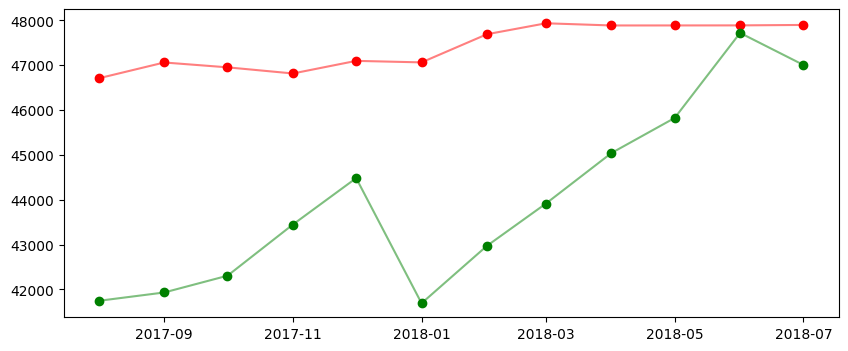

In [ ]:
printer(test3, bagging_ets_forecast_3)

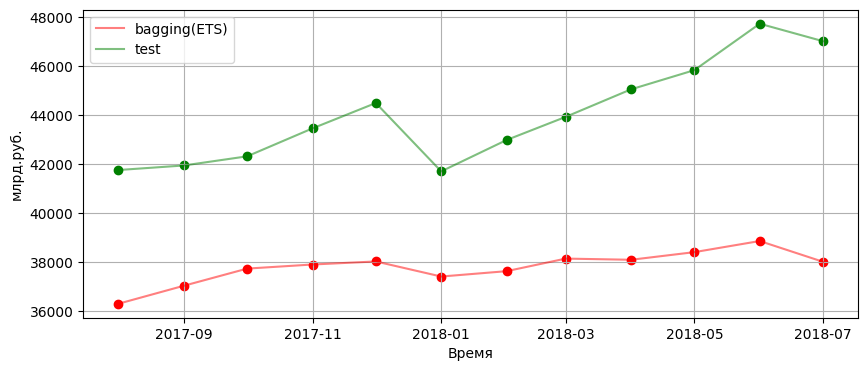

In [ ]:
t = test3
p = bagging_ets_forecast_3
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='bagging(ETS)')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд.руб.')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 2017-08-01    41090.539123
2017-09-01    42142.445086
2017-10-01    42385.720172
2017-11-01    42549.370585
2017-12-01    43358.139047
2018-01-01    40032.624263
2018-02-01    42049.304110
2018-03-01    42512.703134
2018-04-01    43214.272039
2018-05-01    43139.805037
2018-06-01    44507.905269
2018-07-01    43889.953258
Freq: MS, dtype: float64
Test: 	 [41745.5 41931.3 42305.  43446.3 44481.3 41690.4 42971.2 43915.1 45040.1
 45822.8 47718.6 47005.2]
RMSE: 1794.8144443252352
MAE: 1481.9791160627756


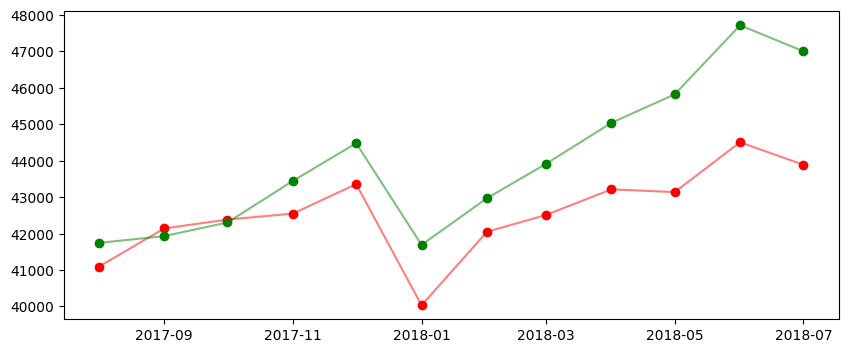

In [ ]:
printer(test3, ets_pred_3)

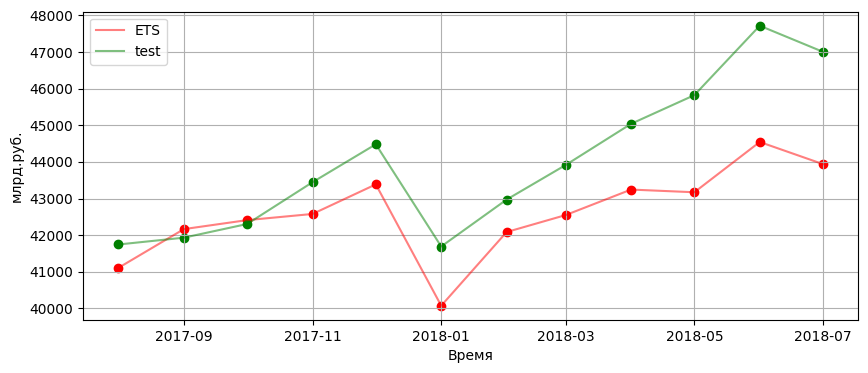

In [ ]:
t = test3
p = ets_pred_3
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='ETS')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд.руб.')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 [41091.64820512 42141.55176093 41521.50289202 42441.11013124
 42998.64518777 42145.06179219 43233.75859613 42932.17178592
 42858.05089391 43510.78899893 43169.29908704 43178.05176863]
Test: 	 [41745.5 41931.3 42305.  43446.3 44481.3 41690.4 42971.2 43915.1 45040.1
 45822.8 47718.6 47005.2]
RMSE: 2061.2699451835597
MAE: 1558.8419332220255


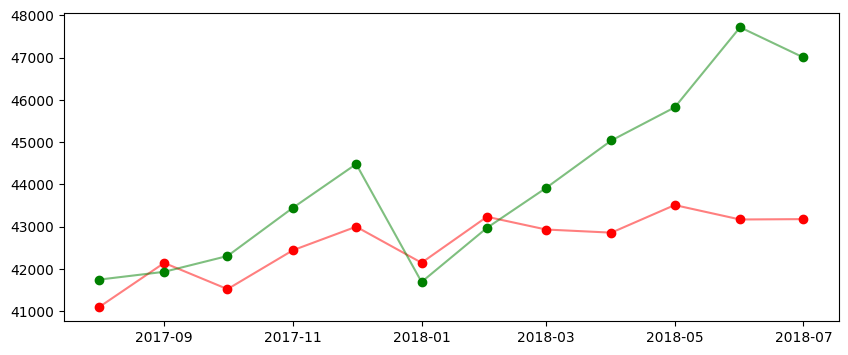

In [ ]:
printer(test3, bagging_arima_forecast_3)

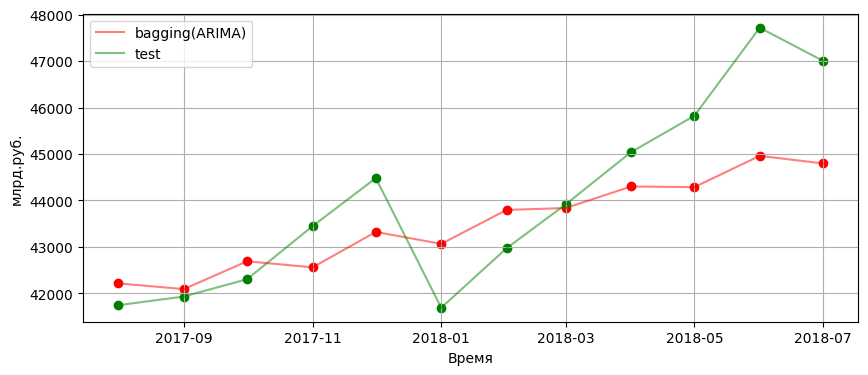

In [ ]:
t = test3
p = bagging_arima_forecast_3
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='bagging(ARIMA)')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд.руб.')
plt.legend()
plt.grid(True)
plt.show()

Pred: 	 2017-08-01    41994.018615
2017-09-01    42714.215914
2017-10-01    42035.612025
2017-11-01    42613.974471
2017-12-01    43521.719898
2018-01-01    42919.725964
2018-02-01    43518.997646
2018-03-01    44355.350687
2018-04-01    43750.883941
2018-05-01    44355.181386
2018-06-01    45198.323588
2018-07-01    44595.153844
Freq: MS, dtype: float64
Test: 	 [41745.5 41931.3 42305.  43446.3 44481.3 41690.4 42971.2 43915.1 45040.1
 45822.8 47718.6 47005.2]
RMSE: 1301.98860181692
MAE: 1083.104972727282


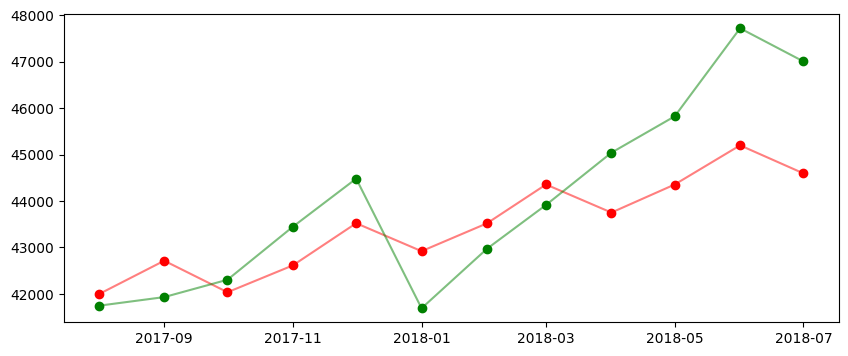

In [ ]:
printer(test3, arima_pred_3)

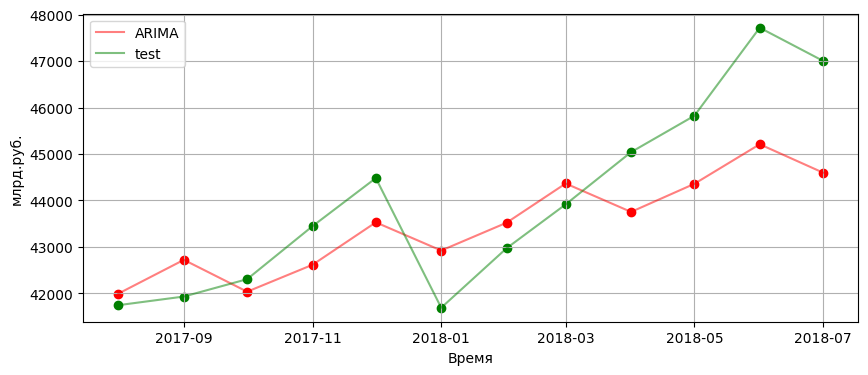

In [ ]:
t = test3
p = arima_pred_3
plt.figure(figsize=(10,4))
plt.scatter(t.index, p, color = 'red')
plt.plot(t.index, p, color = 'red', alpha = 0.5, label='ARIMA')
plt.scatter(t.index, t, color = 'green')
plt.plot(t.index, t, color = 'green', alpha = 0.5, label='test')
plt.xlabel('Время')
plt.ylabel('млрд.руб.')
plt.legend()
plt.grid(True)
plt.show()